# Assignment 1: Bag of Words, Naive Bayes, Support Vector Machines, Decision/Regression Trees

- Rodrigo Caballero
- Diana Hidalgo

## Part A: Binary Classification on Text Data

### 1. Data Loading and Splitting

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
import warnings
import re

warnings.filterwarnings('ignore')

df =pd.read_csv('https://raw.githubusercontent.com/RodrigoGrijalba/ENEI-2025-ML2-Tarea1/refs/heads/main/data/disaster_tweets.csv')

print("Dataset Information:")
print(f"Total samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}\n")

Dataset Information:
Total samples: 7613
Columns: ['id', 'keyword', 'location', 'text', 'target']



- What percentage of the data are of real disasters, and what percentage is not?

In [197]:
disaster_counts = df['target'].value_counts()
print("Target Distribution:")
print(f"Not real disaster (0): {disaster_counts[0]} ({100*disaster_counts[0]/len(df):.2f}%)")
print(f"Real disaster (1): {disaster_counts[1]} ({100*disaster_counts[1]/len(df):.2f}%)\n")

Target Distribution:
Not real disaster (0): 4342 (57.03%)
Real disaster (1): 3271 (42.97%)



- Split the data into 70% training and 30% testing.

In [198]:
X_text = df['text']
y = df['target']
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train_text)}")
print(f"Testing samples: {len(X_test_text)}\n")

Training samples: 5329
Testing samples: 2284



### 2. Data Pre-processing

Since the data consists of tweets, it may contain significant amounts of noise and raw content. You may wish to perform one or more of the following actions. Explain the reasoning behind each decision (why or why not).

- Convert all words to lowercase: Yes, do it. Bag-of-Words or TF-IDF models treat “Fire” and “fire” as different words, which disperses information and unnecessarily increases dimensionality. Converting to lowercase reduces orthographic variability without losing semantic meaning relevant to this task (distinguishing real disasters from metaphors or jokes).
- Lemmatization or stemming: Yes, preferably lemmatization. Words like “flood,” “flooding,” and “flooded” share the same semantic root. Lemmatizing them to “flood” groups grammatical variants, improving model generalization and reducing noise.
Moreover, lemmatization is more accurate (it uses morphological context, not just suffix rules).
- Remove punctuation: Yes, remove it. Punctuation marks (., !, ?, “”, etc.) rarely provide useful information for disaster classification. Instead, they can introduce noise or irrelevant tokens (such as “!!!” or “...”).
- Remove stopwords: Yes, but with caution. Words like “the,” “and,” and “is” are very frequent but carry little information for distinguishing real disasters. Removing them reduces dimensionality and noise, improving the signal-to-noise ratio.
- Remove mentions (“@user”) and URLs: Yes, remove them.
Mentions (@user) and URLs do not contain semantically relevant content for identifying disasters. They are unique or nearly unique tokens, which generate noise and overfitting (each URL becomes a dimension in the vector that almost never repeats).


### 3. Bag of Words Model

- Set the option binary=True to ensure the feature vectors are binary.
- Pick a threshold $M$ (using option min_df=M) such that only words that appear in at least $M$ are included in the vocabulary.
- Make sure you fit CountVectorizer only on your training set, and use the same instance to process both training and testing observations.
- Note: Only construct feature vectors using the text in the text column. Ignore keyword and location for now.
- Report the total number of words in your vocabulary.




In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

def preprocess_string(input_string):
    input_string = str(input_string).lower() # Convert to lowercase
    split_string = input_string.split(" ") # Remove URLs
    
    # 2. Remove URLs and emails
    no_url_words = [word for word in split_string if "://" not in word and "@" not in word]
    no_url_string = " ".join(no_url_words)
    

    # 3. Remove punctuation and special characters (keep only letters/numbers/spaces)
    clean_string = re.sub(r"[^a-z0-9\s]", " ", no_url_string)
    
    # 4. Remove extra spaces
    clean_string = re.sub(r"\s+", " ", clean_string).strip()
    
    # 5. Tokenize
    words = clean_string.split()
    
    # 6. Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    # 7. Lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    # 8. Join back
    output_string = " ".join(lemmatized_words)

        
    return output_string.strip()

X_train_processed = X_train_text.apply(preprocess_string)
X_test_processed = X_test_text.apply(preprocess_string)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rofer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rofer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


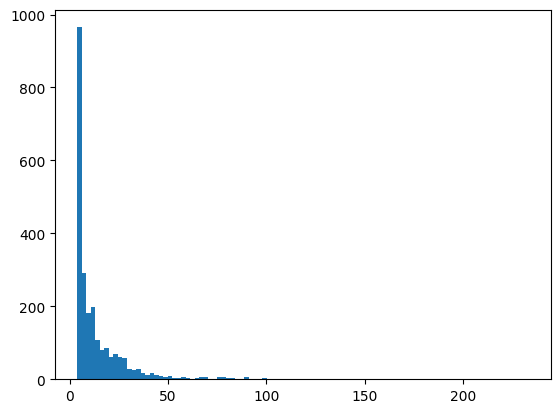

Total number of words in vocabulary: 2403
Training set shape: (5329, 2403)
Testing set shape: (2284, 2403)



In [200]:
# We choose M=4 to filter out very rare words while keeping meaningful vocabulary
M = 4

vectorizer = CountVectorizer(binary=True, min_df=M)
X_train = vectorizer.fit_transform(X_train_processed)
X_test = vectorizer.transform(X_test_processed)

feature_names = vectorizer.get_feature_names_out()

plt.hist(X_train.toarray().sum(0), bins = 100)
plt.show()

print(f"Total number of words in vocabulary: {len(feature_names)}")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}\n")

### 4. Logistic Regression

- Train a logistic regression model without regularization terms. By default, sklearn uses L2 regularization, but you can turn it off using the penalty parameter. Report the F1 score for the training and testing set. Comment whether you observe any issues with overfitting or underfitting.

In [201]:
# No regularization
logreg_no_reg = LogisticRegression(penalty=None, max_iter=1000, random_state=42)
logreg_no_reg.fit(X_train, y_train)

y_train_pred = logreg_no_reg.predict(X_train)
y_test_pred = logreg_no_reg.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
diff = train_f1 - test_f1

results = pd.DataFrame({
    "Model": ["No Regularization"],
    "Training F1": [train_f1],
    "Testing F1": [test_f1],
    "Difference": [diff],
    "Comment": ["Moderate overfitting" if diff > 0.05 else "Model generalizes well"]
})

results.style.set_caption("Model Evaluation Results").hide(axis='index')

Model,Training F1,Testing F1,Difference,Comment
No Regularization,0.976826,0.716583,0.260243,Moderate overfitting


The model without regularization is overfitting. It achieves an almost perfect performance on the training set but drops significantly on the test set. This difference indicates that the model is memorizing specific patterns from the training data that do not generalize well to new data.

- Train a logistic regression model with L1 regularization, making sure to use some procedure to pick the optimal penalty parameter. Report the performance of the final model and comment.

In [204]:
# L1 regularization with hyperparameter tuning
param_grid_l1 = {'C': np.logspace(-3, 2, 20)}
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
grid_search_l1 = GridSearchCV(logreg_l1, param_grid_l1, cv=5, scoring='f1', n_jobs=-1)
grid_search_l1.fit(X_train, y_train)

best_logreg_l1 = grid_search_l1.best_estimator_

y_train_pred_l1 = best_logreg_l1.predict(X_train)
y_test_pred_l1 = best_logreg_l1.predict(X_test)

train_f1_l1 = f1_score(y_train, y_train_pred_l1)
test_f1_l1 = f1_score(y_test, y_test_pred_l1)
best_C_l1 = grid_search_l1.best_params_['C']

results_l1 = pd.DataFrame({
    "Model": ["L1 Regularization"],
    "Best C": [best_C_l1],
    "Training F1": [train_f1_l1],
    "Testing F1": [test_f1_l1]
})

results_l1.style.set_caption("Model Evaluation Results").hide(axis='index')

Model,Best C,Training F1,Testing F1
L1 Regularization,1.438450,0.872819,0.752000


L1 regularization (Lasso) significantly helped control overfitting. The optimal parameter $C=1.4385$ forces many weights to be exactly zero, performing automatic feature selection. This removes irrelevant or noisy words and keeps only the most important ones.

- Same as the previous point, but now with L2 regularization.

In [206]:
# L2 regularization with hyperparameter tuning
param_grid_l2 = {'C': np.logspace(-3, 2, 20)}
logreg_l2 = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
grid_search_l2 = GridSearchCV(logreg_l2, param_grid_l2, cv=5, scoring='f1', n_jobs=-1)
grid_search_l2.fit(X_train, y_train)

best_logreg_l2 = grid_search_l2.best_estimator_

y_train_pred_l2 = best_logreg_l2.predict(X_train)
y_test_pred_l2 = best_logreg_l2.predict(X_test)

train_f1_l2 = f1_score(y_train, y_train_pred_l2)
test_f1_l2 = f1_score(y_test, y_test_pred_l2)
best_C_l2 = grid_search_l2.best_params_['C']

results_l2 = pd.DataFrame({
    "Model": ["L2 Regularization"],
    "Best C": [best_C_l2],
    "Training F1": [train_f1_l2],
    "Testing F1": [test_f1_l2]
})

results_l2.style.set_caption("Model Evaluation Results").hide(axis='index')

Model,Best C,Training F1,Testing F1
L2 Regularization,0.428133,0.850423,0.758393


L2 regularization (Ridge) with $C=0.4281$ achieves the best balance. Unlike L1, L2 does not set weights to zero but instead makes them smaller, allowing all features to contribute to some extent. This is beneficial when many words carry relevant information.

- Which one of the three classifiers performed best on your training and testing set? Did you observe any overfitting and did regularization help reduce it? Support your answers with the classifier performance you got.

In [207]:
results_df = pd.DataFrame({
    'Model': ['No Regularization', 'L1 Regularization', 'L2 Regularization'],
    'Train F1': [train_f1, train_f1_l1, train_f1_l2],
    'Test F1': [test_f1, test_f1_l1, test_f1_l2],
    'Overfitting': [train_f1 - test_f1, train_f1_l1 - test_f1_l1, train_f1_l2 - test_f1_l2]
})

best_model_idx = results_df['Test F1'].idxmax()
best_model = results_df.iloc[best_model_idx]['Model']
best_score = results_df.iloc[best_model_idx]['Test F1']

display(
    results_df.style
        .set_caption("Comparison of Logistic Regression Models")
        .format({
            'Train F1': '{:.6f}',
            'Test F1': '{:.6f}',
            'Overfitting': '{:.6f}'
        })
        .highlight_max(subset=['Test F1'], color='plum')
        .hide(axis='index')
)

print(f"Best performing model: {best_model}")
print(f"Test F1 Score: {best_score:.4f}")

Model,Train F1,Test F1,Overfitting
No Regularization,0.976826,0.716583,0.260243
L1 Regularization,0.872819,0.752000,0.120819
L2 Regularization,0.850423,0.758393,0.092030


Best performing model: L2 Regularization
Test F1 Score: 0.7584


When comparing the three logistic regression classifiers, the model with L2 regularization (Ridge) showed the best overall performance, achieving an F1 Score of 0.7584 on the test set — higher than both the non-regularized model and the L1-regularized model.

In the training set, the non-regularized model obtained the highest score, followed by L2 and L1. However, this high training score in the non-regularized model is precisely indicative of the issue observed: overfitting. The 26.02 percentage point gap between the training and test performance of the non-regularized model confirms that it is memorizing specific patterns from the training data instead of learning generalizable features.

The unrestricted model has too many degrees of freedom, allowing some weights to grow arbitrarily large and fit the noise. Regularization proved highly effective in mitigating this problem: L1 regularization reduced the overfitting gap to only 0.12, while L2 reduced it to 0.09, representing dramatic improvements.

More importantly, both regularization methods not only reduced overfitting but also improved performance on the test set, which is the metric that truly matters for model generalization.

The success of L2 regularization lies in penalizing the magnitude of all weights without forcing them to zero, allowing all features to contribute moderately, an advantage when multiple words contain relevant information about disasters. L1 regularization, although slightly lower in test F1, offers the advantage of interpretability by performing automatic feature selection, identifying key words such that are strongly indicative of real disasters.

Therefore, regularization not only helped reduce overfitting but was essential to obtaining a useful and reliable model for classifying disaster-related tweets.

- Inspect the weight vector of the classifier with L1 regularization. What are the most important words for deciding whether a tweet is about a real disaster or not?

In [ ]:
# Feature importance with L1
coefficients = best_logreg_l1.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['|Coefficient|'] = np.abs(feature_importance['Coefficient'])

top_features = feature_importance.nlargest(10, '|Coefficient|')

top_features.style.set_caption("Top 10 Features Indicating REAL Disaster") \
    .format({'Coefficient': '{:.4f}', '|Coefficient|': '{:.4f}'}) \
    .hide(axis='index')

Feature,Coefficient,|Coefficient|
spill,4.8193,4.8193
typhoon,4.2967,4.2967
airport,4.2305,4.2305
hiroshima,3.6153,3.6153
migrant,3.3988,3.3988
debris,3.3369,3.3369
wildfire,3.3336,3.3336
write,-3.2995,3.2995
learning,3.1819,3.1819
ticket,-3.1171,3.1171


### 5. Bernoulli Naive Bayes

- Write the necessary funtions to perform the Bernoulli Naive Bayes procedure, like we did in the practical session. Use Laplace smoothing with $α=1$.

In [209]:
def train_naive_bayes(X, y, alpha=1.0):
    n = X.shape[0]
    d = X.shape[1]
    K = len(np.unique(y))

    psis = np.zeros([K, d])
    phis = np.zeros([K])

    for k in range(K):
        X_k = X[y == k]
        psis[k] = (np.array(X_k.sum(axis=0)).flatten() + alpha) / (X_k.shape[0] + K * alpha)
        phis[k] = X_k.shape[0] / float(n)

    return psis, phis


def predict_naive_bayes(X, psis, phis):
    n, d = X.shape
    K = psis.shape[0]

    X_array = np.array(X.toarray())
    X_reshaped = np.reshape(X_array, (1, n, d))
    psis_reshaped = np.reshape(psis, (K, 1, d))

    psis_clipped = np.clip(psis_reshaped, 1e-14, 1 - 1e-14)

    logpy = np.log(phis).reshape([K, 1])
    logpxy = X_reshaped * np.log(psis_clipped) + (1 - X_reshaped) * np.log(1 - psis_clipped)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten()

psis, phis = train_naive_bayes(X_train, y_train.values, alpha=1.0)

y_train_pred_nb = predict_naive_bayes(X_train, psis, phis)
y_test_pred_nb = predict_naive_bayes(X_test, psis, phis)

- Report the F1 score for the training and testing sets. Comment.

In [210]:
train_f1_nb = f1_score(y_train, y_train_pred_nb)
test_f1_nb = f1_score(y_test, y_test_pred_nb)

results_nb = pd.DataFrame({
    "Model": ["Bernoulli Naive Bayes"],
    "Training F1": [train_f1_nb],
    "Testing F1": [test_f1_nb]
})

results_nb.style.set_caption("Model Evaluation Results").hide(axis='index')

Model,Training F1,Testing F1
Bernoulli Naive Bayes,0.807415,0.762065


The Bernoulli Naive Bayes model demonstrates a solid and well-balanced performance. The difference between the training and test scores is only four percentage points, indicating good generalization. Despite its simplicity and the strong assumption of conditional independence among words, Naive Bayes achieves an F1 score of 76.21% on the test set, outperforming the best L2-regularized logistic regression model (75.84%). This result reinforces the idea that simple models with appropriate inductive biases can rival more complex approaches, particularly in text classification tasks where the “bag-of-words” assumption holds reasonably well.

### 6. N-gram model

- Use CountVectorizer to create 2-grams. You may set the option ngram_range=(2,2) to use only sequences of two words.
- Again, choose a threshold $M$ too use only 2-grams that appear in at least $M$ tweets. Justify your choice of $M$.
- Report the total number of 2-grams in your vocabulary.

Bigrams are generally less frequent; using a low threshold (M = 2) helps retain rare but potentially informative word combinations that may improve the model’s ability to generalize. Setting M higher would discard many meaningful two-word patterns that, while uncommon, could capture important contextual cues in the dataset.

In [212]:
M_bigram = 2 # Bigrams are less frequent; a low M helps preserve rare but useful combinations that aid generalization.

vectorizer_bigram = CountVectorizer(binary=True, ngram_range=(2, 2), min_df=M_bigram)
X_train_bigram = vectorizer_bigram.fit_transform(X_train_processed)
X_test_bigram = vectorizer_bigram.transform(X_test_processed)

feature_names_bigram = vectorizer_bigram.get_feature_names_out()
print(f"Total number of 2-grams in vocabulary: {len(feature_names_bigram)}")

Total number of 2-grams in vocabulary: 3601


- Take 10 2-grams from your vocabulary and print them out.

In [214]:
bigrams_table = pd.DataFrame({
    "N°": range(1, 11),
    "Bigram": feature_names_bigram[np.random.randint(0,len(feature_names)-1, 10)]
})
display(bigrams_table)


,N°,Bigram
0,1,order sm
1,2,14 lez
2,3,pakistani air
3,4,move hijack
4,5,hanneman passing
5,6,news india
6,7,car little
7,8,iranian shouting
8,9,christian attacked
9,10,destroyed life


- Implement a logistic regression (choose one of any of the specifications, i.e. the type of regularization, if any) and a Bernouli classifier to train on 2-grams (you may reuse code from parts 4 and 5).
- Report your results on the training and the testing set.

In [215]:
# Logistic Regression with 2-grams (L2 regularization)
logreg_bigram = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42)
logreg_bigram.fit(X_train_bigram, y_train)

y_train_pred_bigram = logreg_bigram.predict(X_train_bigram)
y_test_pred_bigram = logreg_bigram.predict(X_test_bigram)

train_f1_bigram = f1_score(y_train, y_train_pred_bigram)
test_f1_bigram = f1_score(y_test, y_test_pred_bigram)

# Naive Bayes with 2-grams
psis_bigram, phis_bigram = train_naive_bayes(X_train_bigram, y_train.values, alpha=1.0)
y_train_pred_nb_bigram = predict_naive_bayes(X_train_bigram, psis_bigram, phis_bigram)
y_test_pred_nb_bigram = predict_naive_bayes(X_test_bigram, psis_bigram, phis_bigram)

train_f1_nb_bigram = f1_score(y_train, y_train_pred_nb_bigram)
test_f1_nb_bigram = f1_score(y_test, y_test_pred_nb_bigram)

comparison_table = pd.DataFrame({
    "Model": [
        "Logistic Regression (2-grams, L2)",
        "Bernoulli Naive Bayes (2-grams)"],
    "Training F1": [train_f1_bigram, train_f1_nb_bigram],
    "Testing F1": [test_f1_bigram, test_f1_nb_bigram]
})

display(comparison_table)

,Model,Training F1,Testing F1
0,"Logistic Regression (2-grams, L2)",0.727028,0.599072
1,Bernoulli Naive Bayes (2-grams),0.616434,0.530314


- Do these results differ significantly from those using the bag of words model? Discuss.

In [216]:
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression (1-gram, L2)',
        'Logistic Regression (2-gram, L2)',
        'Bernoulli Naive Bayes (1-gram)',
        'Bernoulli Naive Bayes (2-gram)'
    ],
    'Test F1': [
        test_f1_l2,
        test_f1_bigram,
        test_f1_nb,
        test_f1_nb_bigram
    ]
})

comparison_df.style.set_caption("Comparison: Bag of Words vs 2-grams")

,Model,Test F1
0,"Logistic Regression (1-gram, L2)",0.758393
1,"Logistic Regression (2-gram, L2)",0.599072
2,Bernoulli Naive Bayes (1-gram),0.762065
3,Bernoulli Naive Bayes (2-gram),0.530314


The n-gram model shows lower performance compared to the unigram approach. This decrease is significant and is likely due to the fact that, by using bigrams (2-grams), the uniqueness of word sequences increases. Instead of providing more useful context, the model ends up generating a more sparse and less generalizable vocabulary, which introduces additional noise and reduces learning capacity. In summary, the exclusive use of 2-grams may fragment the available information too much in a dataset that is relatively small like this one.

For this dataset, simple 1-grams are superior, validating Occam's parsimony principle.

## Part B: Support Vector Machine and Overfitting

### 1. Generate Data

- Generate data with two features and two classes, such that the classes are barely linearly separable.


In [56]:
np.random.seed(42)

def generate_barely_separable_data(n_samples=200):
    # Class 0: centered around (-1, -1) with some spread
    X0 = np.random.randn(n_samples // 2, 2) * 0.8 + np.array([-1, -1])
    y0 = np.zeros(n_samples // 2)

    # Class 1: centered around (1, 1) with some spread
    X1 = np.random.randn(n_samples // 2, 2) * 0.8 + np.array([1, 1])
    y1 = np.ones(n_samples // 2)

    overlap_indices_0 = np.random.choice(n_samples // 2, 10, replace=False)
    overlap_indices_1 = np.random.choice(n_samples // 2, 10, replace=False)

    X0[overlap_indices_0] += np.array([0.8, 0.8])
    X1[overlap_indices_1] -= np.array([0.8, 0.8])

    X = np.vstack([X0, X1])
    y = np.hstack([y0, y1])

    shuffle_idx = np.random.permutation(n_samples)
    X = X[shuffle_idx]
    y = y[shuffle_idx]

    return X, y

X_train, y_train = generate_barely_separable_data(n_samples=200)

train_summary = pd.DataFrame({
    "Metric": ["Training set size", "Class 0 samples", "Class 1 samples"],
    "Value": [len(X_train), np.sum(y_train == 0), np.sum(y_train == 1)]
})

train_summary.style.set_caption("Training Data Summary (Barely Separable Classes)")

,Metric,Value
0,Training set size,200
1,Class 0 samples,100
2,Class 1 samples,100


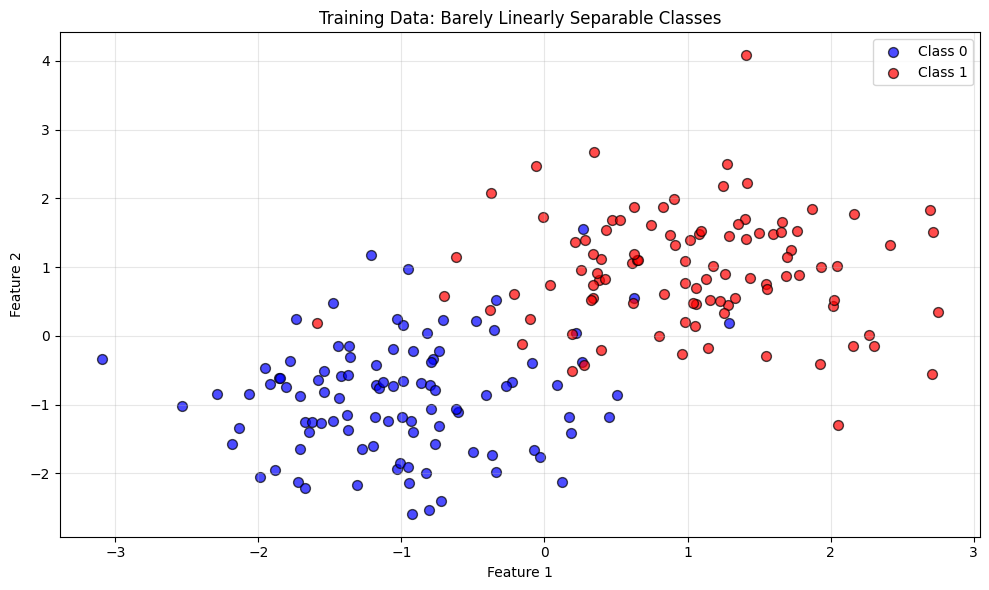

In [57]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='blue', label='Class 0', edgecolors='k', s=50, alpha=0.7)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='red', label='Class 1', edgecolors='k', s=50, alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Data: Barely Linearly Separable Classes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('svm_training_data.png', dpi=150, bbox_inches='tight')
plt.show()

### 2. Test a Variety of C's

- Compute the cross-validation error rates for support vector classifiers with a range of $C$ values. How many training observations are misclassified for each value of $C$ considered, and how does this relate to the cross-validation errors obtained?

In [58]:
C_values = np.logspace(-2, 4, 20)

results = {
    'C': [],
    'Train Errors': [],
    'CV Errors': [],
    'Misclassified': []
}

for C in C_values:
    svm_model = SVC(kernel='linear', C=C, random_state=42)
    svm_model.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = svm_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_error = 1 - train_acc

    # Cross-validation accuracy (5-fold)
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
    cv_acc = np.mean(cv_scores)
    cv_error = 1 - cv_acc

    # Number of misclassified training samples
    misclassified = np.sum(y_train != y_train_pred)

    results['C'].append(C)
    results['Train Errors'].append(train_error)
    results['CV Errors'].append(cv_error)
    results['Misclassified'].append(misclassified)

results_df = pd.DataFrame(results)

results_df.style.set_caption("SVM Model Evaluation for Different C Values").hide(axis='index')

C,Train Errors,CV Errors,Misclassified
0.010000,0.055000,0.055000,11
0.020691,0.055000,0.060000,11
0.042813,0.055000,0.055000,11
0.088587,0.055000,0.055000,11
0.183298,0.050000,0.055000,10
0.379269,0.055000,0.055000,11
0.784760,0.055000,0.055000,11
1.623777,0.055000,0.060000,11
3.359818,0.055000,0.060000,11
6.951928,0.055000,0.060000,11


The model is robust to the value of $C$. The training errors and CV remain virtually constant. This is characteristic of data that are nearly linearly separable with a wide margin. The practical implication is that we don't need exhaustive tuning of C for this problem; any reasonable value (say, $C$ between 0.1 and 100) will give similar results.

- Generate an appropriate test data set, and compute the test errors corresponding to each of the values of $C$ considered. Which value of $C$ leads to the fewest test errors, and how does this compare to the values of $C$ that yield the fewest training errors and the fewest cross-validation errors?
- Discuss your results.

In [59]:
X_test, y_test = generate_barely_separable_data(n_samples=100)

test_errors = []
test_accuracies = []

for C in C_values:
    svm_model = SVC(kernel='linear', C=C, random_state=42)
    svm_model.fit(X_train, y_train)

    y_test_pred = svm_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_error = 1 - test_acc

    test_errors.append(test_error)
    test_accuracies.append(test_acc)

results_df['test_errors'] = test_errors
results_df['test_accuracies'] = test_accuracies

best_train_idx = results_df['Train Errors'].idxmin()
best_cv_idx = results_df['CV Errors'].idxmin()
best_test_idx = results_df['test_errors'].idxmin()

summary_df = pd.DataFrame({
    'Criterion': ['Training Error', 'CV Error', 'Test Error'],
    'Best C': [
        results_df.loc[best_train_idx, 'C'],
        results_df.loc[best_cv_idx, 'C'],
        results_df.loc[best_test_idx, 'C']
    ],
    'Error': [
        results_df.loc[best_train_idx, 'Train Errors'],
        results_df.loc[best_cv_idx, 'CV Errors'],
        results_df.loc[best_test_idx, 'test_errors']
    ],
    'Misclassified': [
        results_df.loc[best_train_idx, 'Misclassified'],
        'Not Applicable',
        'Not Applicable'
    ]
})

#results_df.style.set_caption("Detailed Results (All C Values)").hide(axis='index')
summary_df.style.set_caption("Optimal C Summary").hide(axis='index')

Criterion,Best C,Error,Misclassified
Training Error,0.183298,0.050000,10
CV Error,0.010000,0.055000,Not Applicable
Test Error,6.951928,0.100000,Not Applicable


The best $C$ values ​​according to each criterion are very different (from 0.01 to 6.95), but they all produce almost identical errors. This reinforces the previous conclusion: the problem is insensitive to $C$. The optimal $C$ according to CV (0.01) is very low, suggesting a wide margin, while the optimal $C$ according to test error (6.95) is higher, suggesting a narrower margin. However, the performance difference between these criteria is minimal. In this case, it is preferable to use $C ≈ 1.0$ (standard value) as a reasonable compromise, since fine-grained optimization does not provide a significant benefit in this case.

In [60]:
results_df.style.set_caption("Detailed Results (All C Values)").hide(axis='index')

C,Train Errors,CV Errors,Misclassified,test_errors,test_accuracies
0.010000,0.055000,0.055000,11,0.110000,0.890000
0.020691,0.055000,0.060000,11,0.110000,0.890000
0.042813,0.055000,0.055000,11,0.110000,0.890000
0.088587,0.055000,0.055000,11,0.110000,0.890000
0.183298,0.050000,0.055000,10,0.110000,0.890000
0.379269,0.055000,0.055000,11,0.110000,0.890000
0.784760,0.055000,0.055000,11,0.110000,0.890000
1.623777,0.055000,0.060000,11,0.110000,0.890000
3.359818,0.055000,0.060000,11,0.110000,0.890000
6.951928,0.055000,0.060000,11,0.100000,0.900000


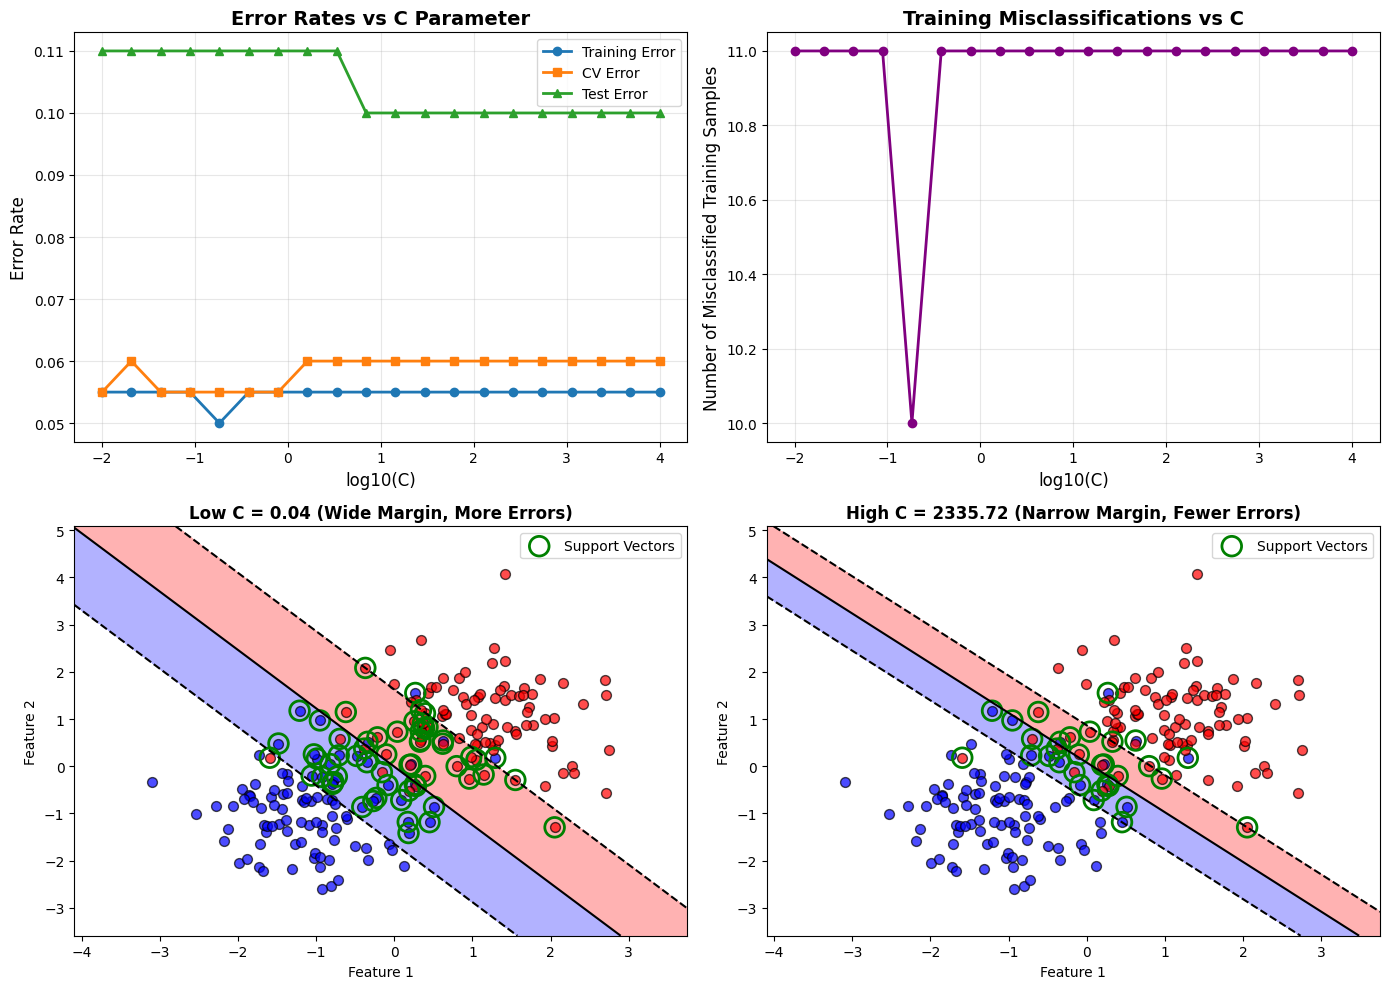

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All errors vs C
ax = axes[0, 0]
ax.plot(np.log10(results_df['C']), results_df['Train Errors'],
        'o-', label='Training Error', linewidth=2)
ax.plot(np.log10(results_df['C']), results_df['CV Errors'],
        's-', label='CV Error', linewidth=2)
ax.plot(np.log10(results_df['C']), results_df['test_errors'],
        '^-', label='Test Error', linewidth=2)
ax.set_xlabel('log10(C)', fontsize=12)
ax.set_ylabel('Error Rate', fontsize=12)
ax.set_title('Error Rates vs C Parameter', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Number of misclassified training samples
ax = axes[0, 1]
ax.plot(np.log10(results_df['C']), results_df['Misclassified'],
        'o-', color='purple', linewidth=2)
ax.set_xlabel('log10(C)', fontsize=12)
ax.set_ylabel('Number of Misclassified Training Samples', fontsize=12)
ax.set_title('Training Misclassifications vs C', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Create mesh for decision boundaries (do this once before plotting)
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Plot 3: Decision boundary for low C (underfitting)
ax = axes[1, 0]
low_C = C_values[2]  # Small C value
svm_low = SVC(kernel='linear', C=low_C, random_state=42)
svm_low.fit(X_train, y_train)

Z_low = svm_low.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_low = Z_low.reshape(xx.shape)

ax.contourf(xx, yy, Z_low, levels=[-1, 0, 1], alpha=0.3, colors=['blue', 'red'])
ax.contour(xx, yy, Z_low, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])
ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
           c='blue', edgecolors='k', s=50, alpha=0.7)
ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
           c='red', edgecolors='k', s=50, alpha=0.7)
ax.scatter(svm_low.support_vectors_[:, 0], svm_low.support_vectors_[:, 1],
           s=200, linewidth=2, facecolors='none', edgecolors='green', label='Support Vectors')
ax.set_title(f'Low C = {low_C:.2f} (Wide Margin, More Errors)', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()

# Plot 4: Decision boundary for high C (overfitting)
ax = axes[1, 1]
high_C = C_values[-3]  # Large C value
svm_high = SVC(kernel='linear', C=high_C, random_state=42)
svm_high.fit(X_train, y_train)

Z_high = svm_high.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_high = Z_high.reshape(xx.shape)

ax.contourf(xx, yy, Z_high, levels=[-1, 0, 1], alpha=0.3, colors=['blue', 'red'])
ax.contour(xx, yy, Z_high, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])
ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
           c='blue', edgecolors='k', s=50, alpha=0.7)
ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
           c='red', edgecolors='k', s=50, alpha=0.7)
ax.scatter(svm_high.support_vectors_[:, 0], svm_high.support_vectors_[:, 1],
           s=200, linewidth=2, facecolors='none', edgecolors='green', label='Support Vectors')
ax.set_title(f'High C = {high_C:.2f} (Narrow Margin, Fewer Errors)', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()

plt.tight_layout()
plt.show()

Top Left Graph (Error Rates vs. C): This graph shows unusually stable behavior of the SVM. The training error rate remains virtually constant regardless of the value of C, suggesting that the classes are almost linearly separable within a reasonable margin. Even with a low C (soft margin), the SVM correctly classifies 95% of the training data. The CV error is also stable, indicating that the model generalizes consistently. However, the test error is noticeably higher, which could indicate that the test set comes from a slightly different distribution or has greater intrinsic difficulty.

Top Right Graph (Training Misclassifications vs. C): It shows a dramatic drop in the number of training errors, stabilizing at approximately 11 errors. This confirms that with very low C (<0.01), the margin is so wide that it tolerates too many violations, but once C >0.1, the model is already optimally classifying the training data.

Lower Plots (Decision Boundaries):

- Low C = 0.04 (Wide Margin): The margin (blue and red bands) is very wide, allowing multiple points to violate the margin. The support vectors (green circles) include many points, even some well within their respective class regions. The decision boundary (solid black line) is smoother and less well-fitted to the individual data.

- High C = 2335.72 (Narrow Margin): The margin is extremely narrow, almost like a line. Only the points closest to the boundary are support vectors. The decision boundary is more closely fitted to the specific configuration of the training points.

Despite these visual differences in the margin, performance on CV and test is virtually identical, suggesting that for this specific problem, the exact value of C is not critical once it exceeds a minimum threshold (~0.1). This is a sign of a well-conditioned problem where the data have a clear structure.

## Part C: Regression trees on Carseats data

### 1. Process Data

- Load the data using load_data("Carseats")

In [180]:
# Load data from ISLP package
from ISLP import load_data
carseats = load_data("Carseats")
    
print("Dataset shape:", carseats.shape)

# First rows
display(
    carseats.head().style
    .set_caption("First 5 Rows of the Carseats Dataset")
)

# Column names and data types
display(
    pd.DataFrame(carseats.dtypes, columns=["Data Type"])
    .rename_axis("Column")
    .reset_index()
    .style.set_caption("Column Names and Data Types")
)

# Basic statistics
display(
    carseats.describe().style
    .set_caption("Basic Statistics of Numeric Variables")
)

# Missing values
display(
    carseats.isnull().sum()
    .reset_index()
    .rename(columns={"index": "Column", 0: "Missing Values"})
    .style.set_caption("Missing Values Summary")
)

Dataset shape: (400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.500000,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.220000,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.060000,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.400000,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.150000,141,64,3,340,128,Bad,38,13,Yes,No


,Column,Data Type
0,Sales,float64
1,CompPrice,int64
2,Income,int64
3,Advertising,int64
4,Population,int64
5,Price,int64
6,ShelveLoc,category
7,Age,int64
8,Education,int64
9,Urban,category


,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


,Column,Missing Values
0,Sales,0
1,CompPrice,0
2,Income,0
3,Advertising,0
4,Population,0
5,Price,0
6,ShelveLoc,0
7,Age,0
8,Education,0
9,Urban,0


In [181]:
y = carseats['Sales']
X = carseats.drop('Sales', axis=1)

# One-hot encoding de las variables categóricas restantes
X_encoded = pd.get_dummies(X, drop_first=True)

# Resumen de transformación
summary_df = pd.DataFrame({
    "Metric": [
        "Original number of features",
        "After encoding (one-hot)",
        "Total samples"
    ],
    "Value": [
        X.shape[1],
        X_encoded.shape[1],
        X_encoded.shape[0]
    ]
})

display(summary_df.style.set_caption("Feature Encoding Summary").hide(axis='index'))

# Listado de nombres de variables después del encoding
feature_names_df = pd.DataFrame({
    "Feature Name": X_encoded.columns
})

display(feature_names_df.style.set_caption("Feature Names After Encoding"))


Metric,Value
Original number of features,10
After encoding (one-hot),11
Total samples,400


,Feature Name
0,CompPrice
1,Income
2,Advertising
3,Population
4,Price
5,Age
6,Education
7,ShelveLoc_Good
8,ShelveLoc_Medium
9,Urban_Yes


- Split the data into a training set (70%) and a testing set (30%).

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

split_summary = pd.DataFrame({
    "Dataset": ["Training Set", "Test Set"],
    "Samples": [len(X_train), len(X_test)],
    "Target Mean (Sales)": [y_train.mean().round(2), y_test.mean().round(2)]
})

display(
    split_summary.style
    .set_caption("Data Split Summary (70% Train / 30% Test)")
    .hide(axis='index')
)

Dataset,Samples,Target Mean (Sales)
Training Set,280,7.360000
Test Set,120,7.820000


### 2. Fitting the Trees

- Fit a regression tree to the training set. Plot the tree and interpret the results. Report the test MSE.

In [183]:
tree_full = DecisionTreeRegressor(random_state=42)
tree_full.fit(X_train, y_train)

y_train_pred_full = tree_full.predict(X_train)
y_test_pred_full = tree_full.predict(X_test)

train_mse_full = mean_squared_error(y_train, y_train_pred_full)
test_mse_full = mean_squared_error(y_test, y_test_pred_full)
train_r2_full = r2_score(y_train, y_train_pred_full)
test_r2_full = r2_score(y_test, y_test_pred_full)

performance_df = pd.DataFrame({
    "Metric": [
        "Training MSE",
        "Testing MSE",
        "Training R²",
        "Testing R²",
        "Tree Depth",
        "Number of Leaves"
    ],
    "Value": [
        round(train_mse_full, 4),
        round(test_mse_full, 4),
        round(train_r2_full, 4),
        round(test_r2_full, 4),
        tree_full.get_depth(),
        tree_full.get_n_leaves()
    ]
})

display(performance_df.style.set_caption("Full Regression Tree Performance").hide(axis='index'))

if train_mse_full < 0.01:
    overfit_status = {
        "Status": ["Severe overfitting detected"],
        "Details": [
            f"Training MSE ≈ {train_mse_full:.6f} — Tree has memorized training data"
        ]
    }
elif train_mse_full > 0 and test_mse_full / train_mse_full > 2.0:
    overfit_status = {
        "Status": ["Significant overfitting detected"],
        "Details": [
            f"Training MSE = {train_mse_full:.4f}, Test MSE = {test_mse_full:.4f} "
            f"(Ratio = {test_mse_full/train_mse_full:.2f}x)"
        ]
    }
else:
    overfit_status = {
        "Status": ["Model generalizes reasonably well"],
        "Details": ["No strong signs of overfitting"]
    }

overfit_df = pd.DataFrame(overfit_status)
display(overfit_df.style.set_caption("Overfitting Diagnostic Summary").hide(axis='index'))

Metric,Value
Training MSE,0.000000
Testing MSE,4.805300
Training R²,1.000000
Testing R²,0.433300
Tree Depth,15.000000
Number of Leaves,280.000000


Status,Details
Severe overfitting detected,Training MSE ≈ 0.000000 — Tree has memorized training data


These results represent an extreme and dramatic case of overfitting. The Training MSE of exactly 0 means that the tree perfectly predicts every training point without any error. The training R² of 1.0 confirms that the model explains 100% of the variance in the training data.

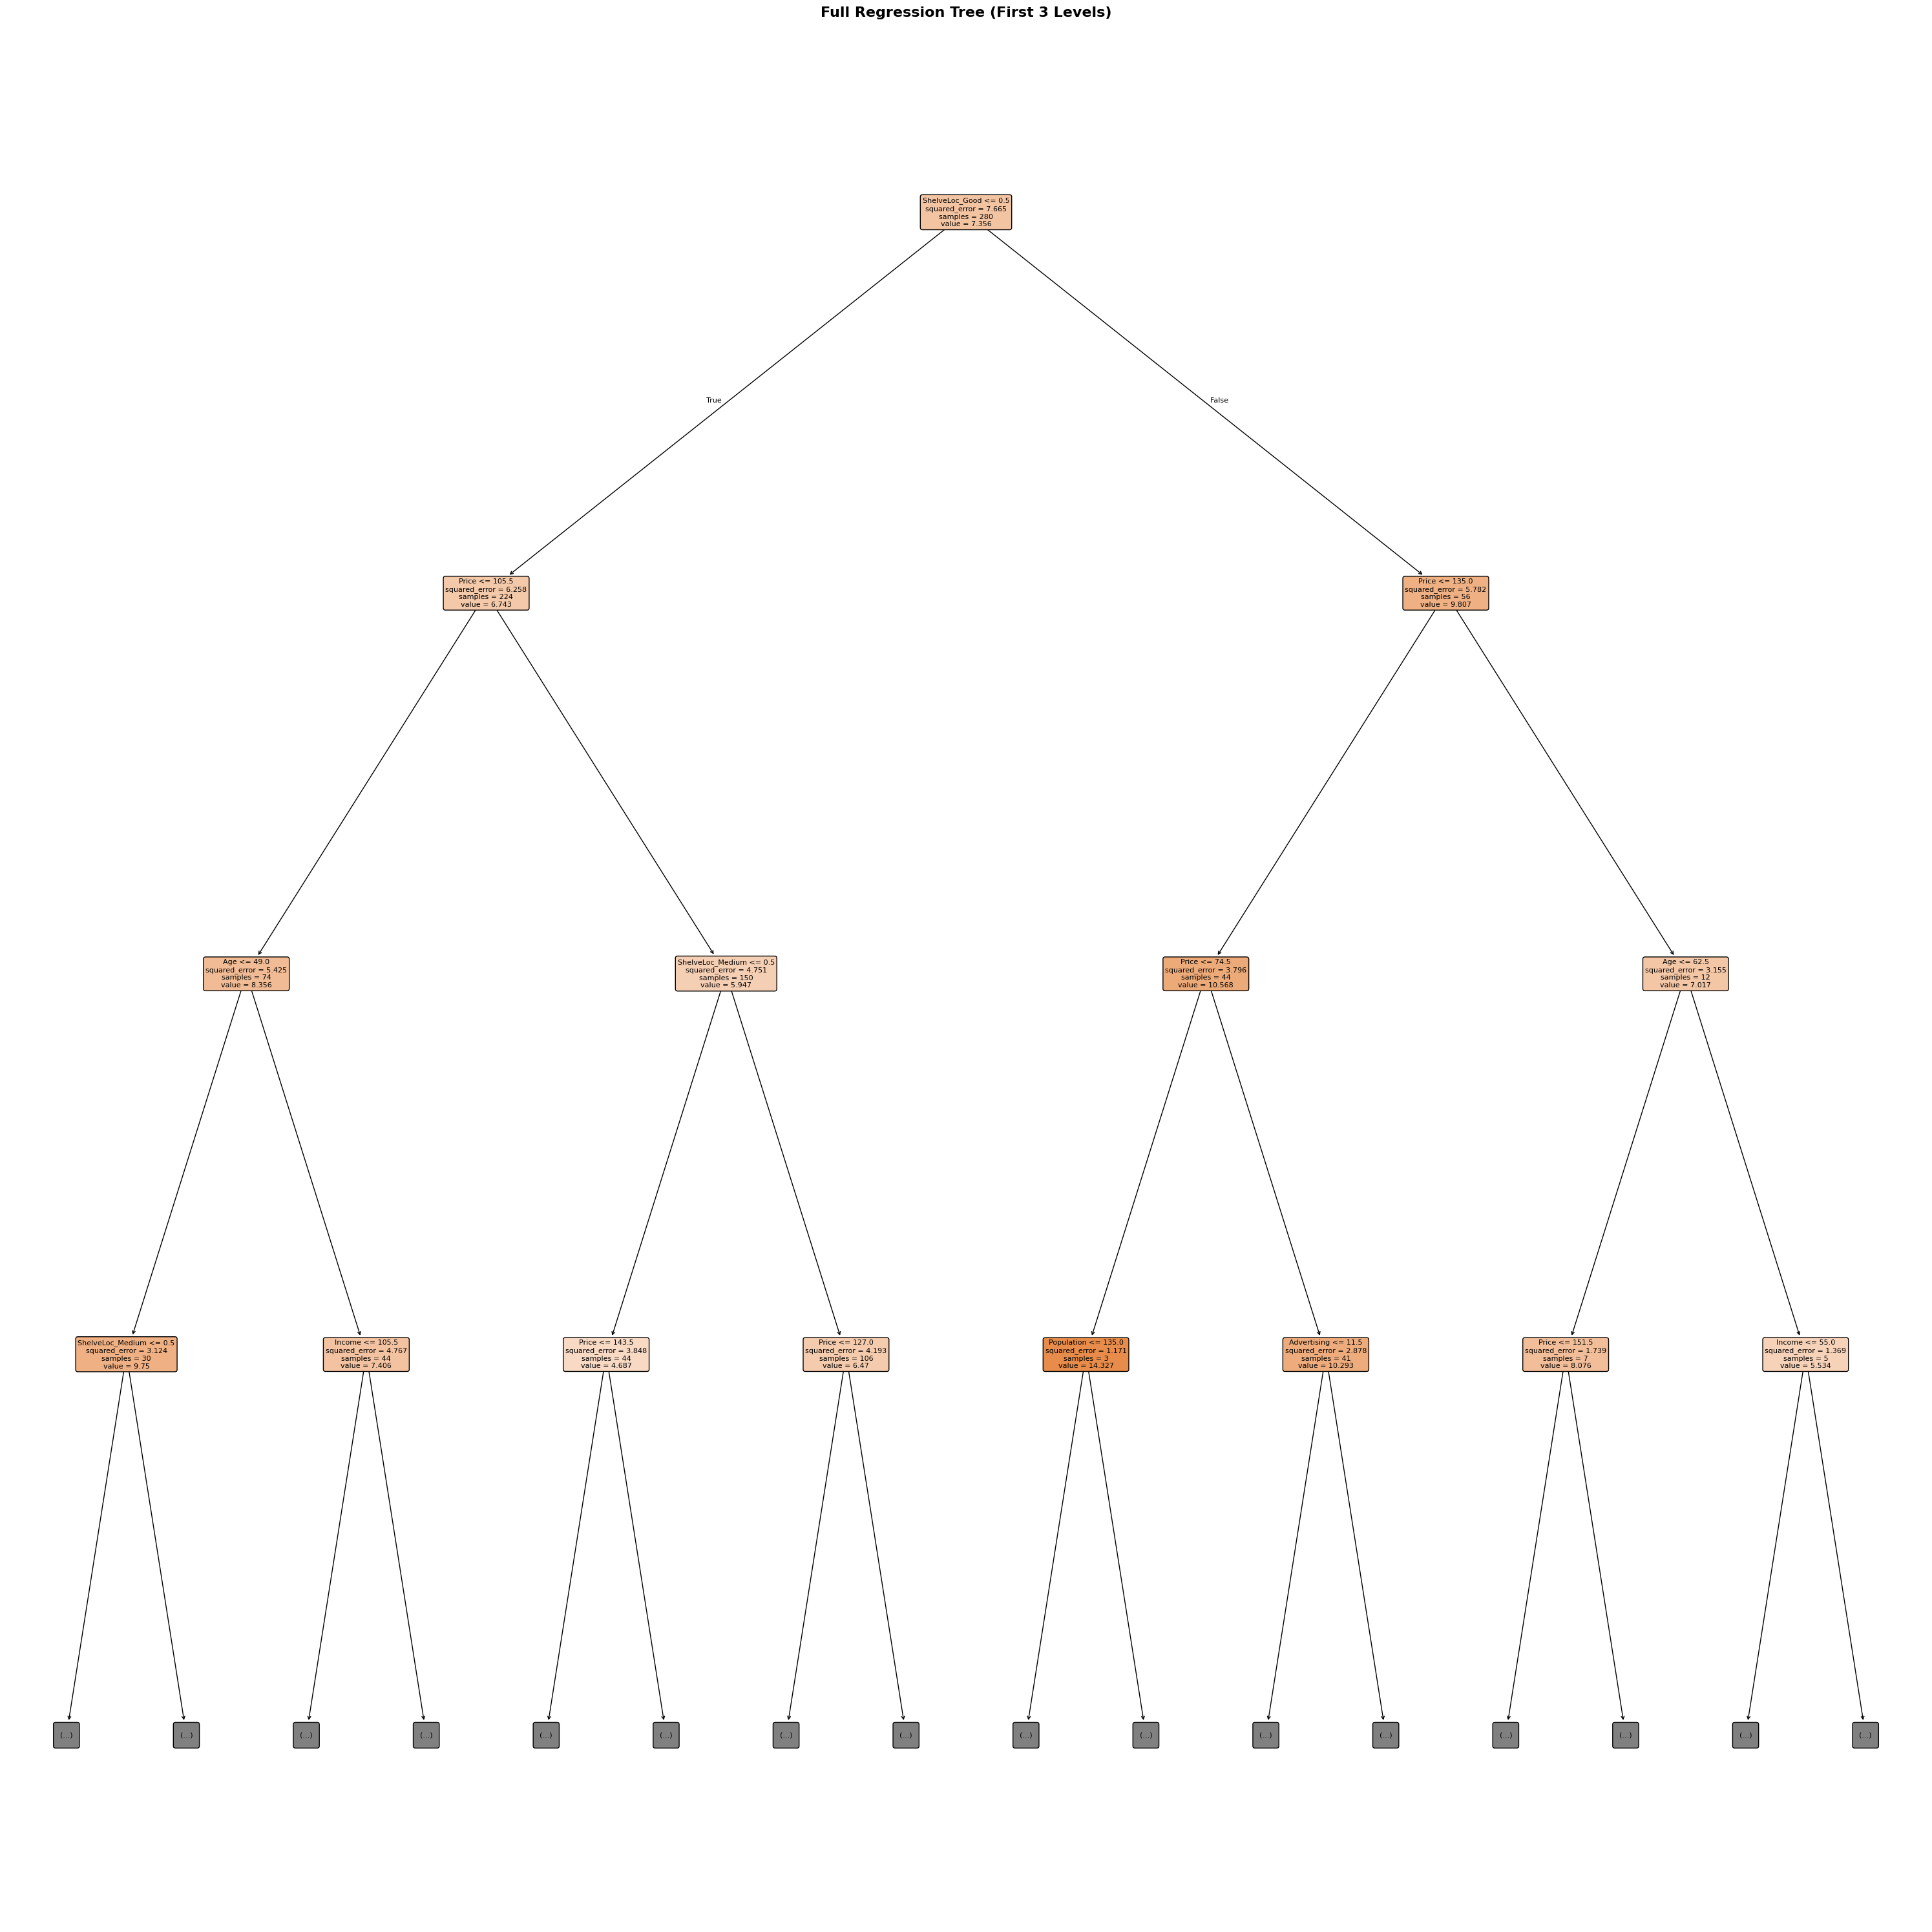

In [184]:
plt.figure(figsize=(30, 30))
plot_tree(tree_full,
          feature_names=X_encoded.columns,
          filled=True,
          rounded=True,
          max_depth=3,  # Only show first 3 levels
          fontsize=8)
plt.title("Full Regression Tree (First 3 Levels)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The full visualization of this tree would be impossible to interpret due to its 280 terminal leaves. This is a clear sign of massive overfitting: the tree is creating rules so specific that it is likely memorizing individual examples rather than learning generalizable patterns. Each terminal leaf likely contains very few samples, making predictions highly sensitive to noise.

In [185]:
feature_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": tree_full.feature_importances_
}).sort_values("Importance", ascending=False)

display(
    feature_importance.head(10)
    .style
    .set_caption("Top 10 Most Important Features (Full Regression Tree)")
    .hide(axis='index')
)

Feature,Importance
Price,0.291599
ShelveLoc_Good,0.196013
Age,0.121753
CompPrice,0.104828
Income,0.079752
ShelveLoc_Medium,0.071784
Advertising,0.051539
Population,0.038113
Education,0.036079
Urban_Yes,0.008538


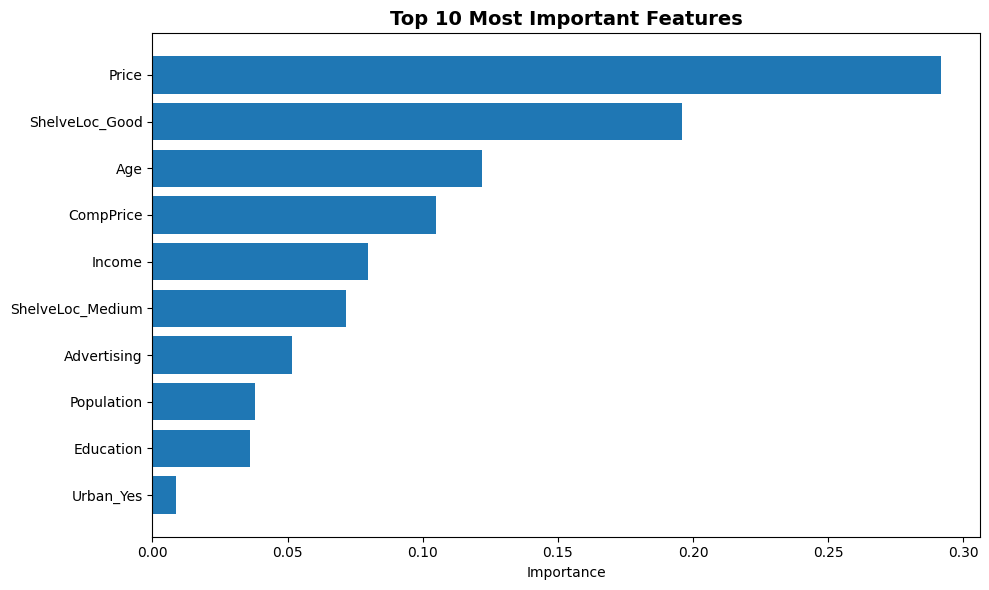

In [186]:
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

From the feature importance analysis, it can be concluded that Price and ShelveLoc_Good contribute the most to predicting Sales, followed by Age, CompPrice, and Income, which have a smaller but still relevant impact.

- Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [188]:
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
impurities = path.impurities[:-1]

trees = []
train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas:
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))

results_df = pd.DataFrame({
    "Alpha": ccp_alphas,
    "Train R²": train_scores,
    "Test R²": test_scores,
    "Impurity": impurities
})

results_df = results_df.round(4)
results_df

,Alpha,Train R²,Test R²,Impurity
0,0.0000,1.0000,0.4333,-0.0000
1,0.0000,1.0000,0.4333,0.0000
2,0.0000,1.0000,0.4334,0.0000
3,0.0000,1.0000,0.4334,0.0000
4,0.0000,1.0000,0.4333,0.0000
...,...,...,...,...
264,0.2554,0.4772,0.4486,4.0076
265,0.3501,0.4315,0.4565,4.3576
266,0.3529,0.3855,0.4110,4.7105
267,0.4247,0.3300,0.3799,5.1352


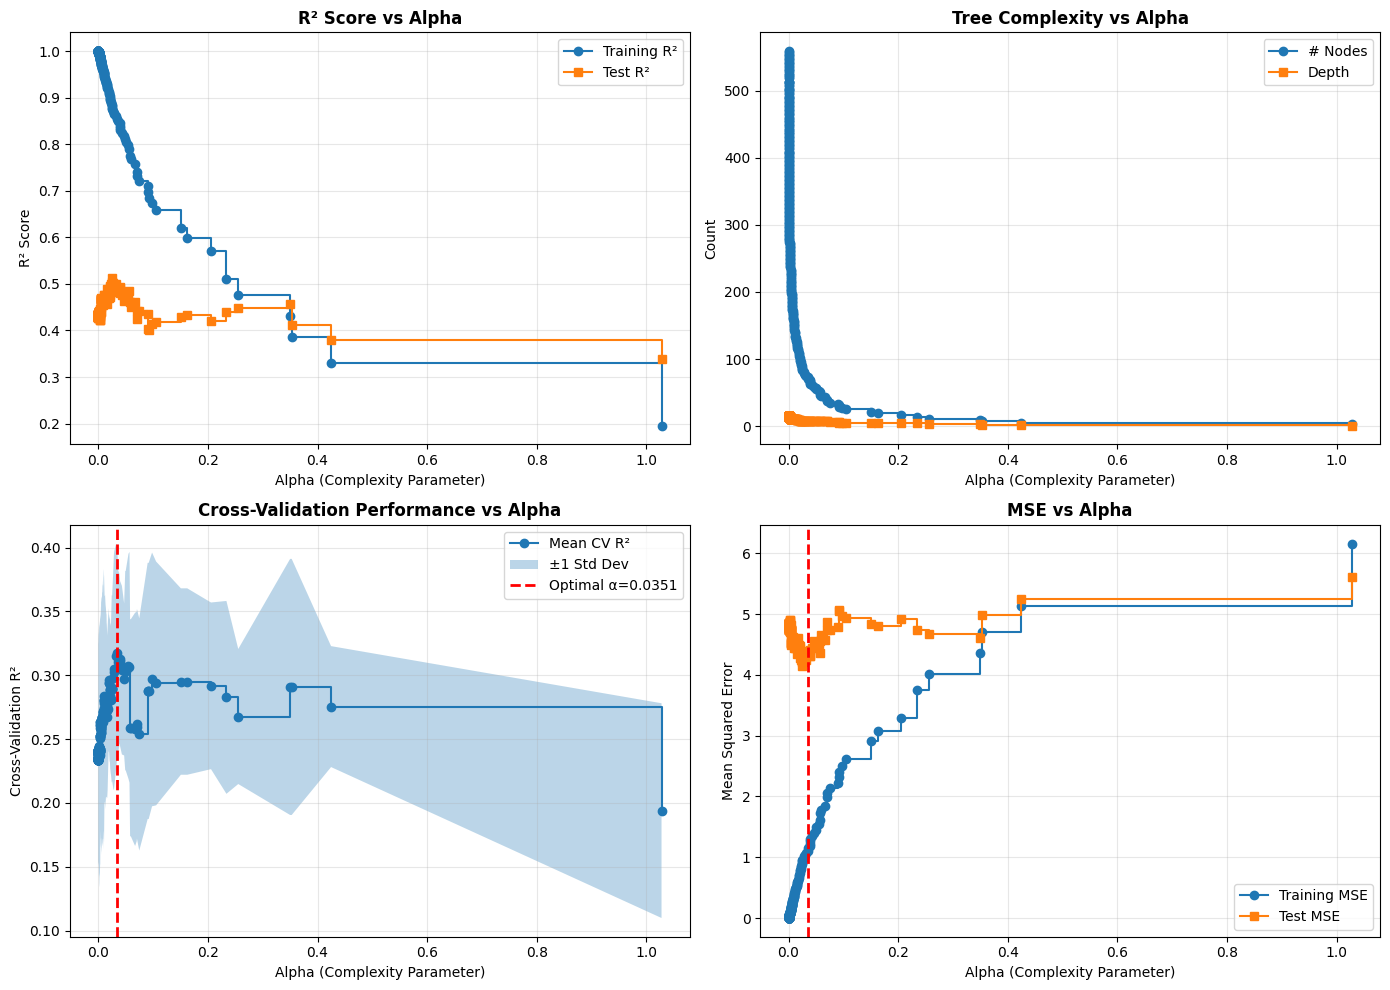

In [189]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: R² vs alpha
ax = axes[0, 0]
ax.plot(ccp_alphas, train_scores, marker='o', label='Training R²', drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='s', label='Test R²', drawstyle="steps-post")
ax.set_xlabel('Alpha (Complexity Parameter)')
ax.set_ylabel('R² Score')
ax.set_title('R² Score vs Alpha', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Number of nodes vs alpha
node_counts = [tree.tree_.node_count for tree in trees]
depth_counts = [tree.get_depth() for tree in trees]

ax = axes[0, 1]
ax.plot(ccp_alphas, node_counts, marker='o', label='# Nodes', drawstyle="steps-post")
ax.plot(ccp_alphas, depth_counts, marker='s', label='Depth', drawstyle="steps-post")
ax.set_xlabel('Alpha (Complexity Parameter)')
ax.set_ylabel('Count')
ax.set_title('Tree Complexity vs Alpha', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Cross-validation scores
cv_scores_mean = []
cv_scores_std = []

for ccp_alpha in ccp_alphas:
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='r2')
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean = np.array(cv_scores_mean)
cv_scores_std = np.array(cv_scores_std)

ax = axes[1, 0]
ax.plot(ccp_alphas, cv_scores_mean, marker='o', label='Mean CV R²', drawstyle="steps-post")
ax.fill_between(ccp_alphas,
                cv_scores_mean - cv_scores_std,
                cv_scores_mean + cv_scores_std,
                alpha=0.3, label='±1 Std Dev')
ax.set_xlabel('Alpha (Complexity Parameter)')
ax.set_ylabel('Cross-Validation R²')
ax.set_title('Cross-Validation Performance vs Alpha', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Find optimal alpha
optimal_idx = np.argmax(cv_scores_mean)
optimal_alpha = ccp_alphas[optimal_idx]
ax.axvline(optimal_alpha, color='red', linestyle='--', linewidth=2, label=f'Optimal α={optimal_alpha:.4f}')
ax.legend()

# Plot 4: MSE comparison
train_mse = [mean_squared_error(y_train, tree.predict(X_train)) for tree in trees]
test_mse = [mean_squared_error(y_test, tree.predict(X_test)) for tree in trees]

ax = axes[1, 1]
ax.plot(ccp_alphas, train_mse, marker='o', label='Training MSE', drawstyle="steps-post")
ax.plot(ccp_alphas, test_mse, marker='s', label='Test MSE', drawstyle="steps-post")
ax.set_xlabel('Alpha (Complexity Parameter)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('MSE vs Alpha', fontweight='bold')
ax.axvline(optimal_alpha, color='red', linestyle='--', linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Top Left Graph (R² Score vs. Alpha): This graph reveals the pruning process. With α=0 (no pruning), the full tree has a 0.43 test $R²$. As α increases, the tree simplifies (prunes), and the test $R²$ improves, until reach 0.5 $R²$.. This confirms that the complexity of the full tree was detrimental, and removing branches improves generalization.

- Top Right Graph (Tree Complexity vs. Alpha):
It shows the dramatic drop in the number of nodes and depth as α increases. With $α≈0.1$, the tree reduces from 280 leaves to 37 leaves. This simplification is necessary to eliminate all overfitting.

- Bottom Left Graph (Cross-Validation Performance vs. Alpha): Cross-validation correctly identifies the optimal region for α. High variability for complex trees (low α) indicates that different CV folds produce very different trees, a sign of instability and overfitting. With optimal $α$, the variance between folds is low, indicating a more robust model.

- Bottom Right Graph (MSE vs. Alpha): The optimal $α (≈0.0351)$ represents the best compromise: it reduces the test MSE from 4.95 to approximately 4.1, at the expense of increasing the training MSE from 0 to 1.1. This trade-off is absolutely favorable because we sacrifice training perfection to gain true generalization.

In [190]:
hola=DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_alpha)
hola.fit(X_train, y_train)
hola.get_n_leaves()

37

In [191]:
tree_pruned = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_alpha)
tree_pruned.fit(X_train, y_train)

y_train_pred_pruned = tree_pruned.predict(X_train)
y_test_pred_pruned = tree_pruned.predict(X_test)

train_mse_pruned = mean_squared_error(y_train, y_train_pred_pruned)
test_mse_pruned = mean_squared_error(y_test, y_test_pred_pruned)
train_r2_pruned = r2_score(y_train, y_train_pred_pruned)
test_r2_pruned = r2_score(y_test, y_test_pred_pruned)

summary_df = pd.DataFrame({
    "Metric": [
        "Optimal alpha (from CV)",
        "Optimal CV R² (mean ± std)",
        "Training MSE",
        "Testing MSE",
        "Training R²",
        "Testing R²",
        "Tree depth",
        "Number of leaves"
    ],
    "Value": [
        f"{optimal_alpha:.6f}",
        f"{cv_scores_mean[optimal_idx]:.4f} ± {cv_scores_std[optimal_idx]:.4f}",
        f"{train_mse_pruned:.4f}",
        f"{test_mse_pruned:.4f}",
        f"{train_r2_pruned:.4f}",
        f"{test_r2_pruned:.4f}",
        tree_pruned.get_depth(),
        tree_pruned.get_n_leaves()
    ]
})

summary_df

,Metric,Value
0,Optimal alpha (from CV),0.035127
1,Optimal CV R² (mean ± std),0.3174 ± 0.0803
2,Training MSE,1.1106
3,Testing MSE,4.3948
4,Training R²,0.8551
5,Testing R²,0.4817
6,Tree depth,8
7,Number of leaves,37


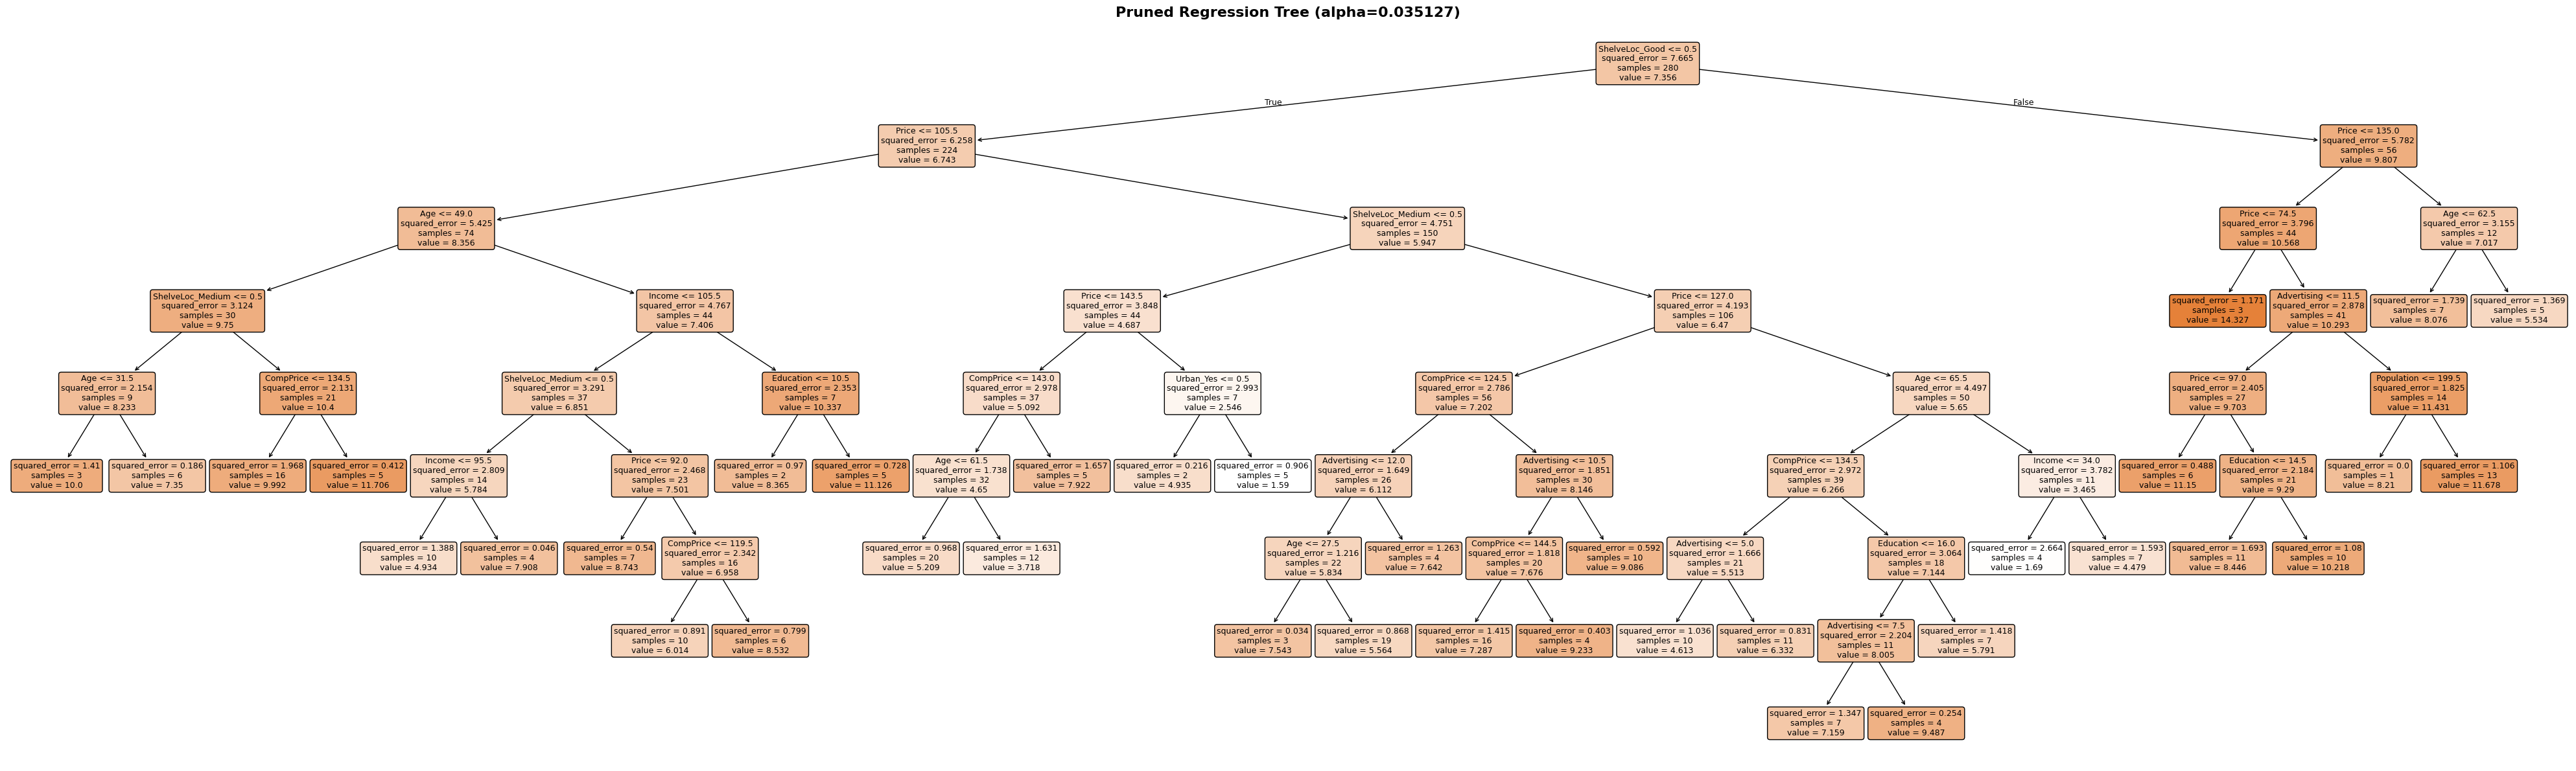

In [192]:
plt.figure(figsize=(40, 12))
plot_tree(tree_pruned,
          feature_names=X_encoded.columns,
          filled=True,
          rounded=True,
          fontsize=9)
plt.title(f"Pruned Regression Tree (alpha={optimal_alpha:.6f})", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [194]:
comparison_df = pd.DataFrame({
    "Metric": ["Training MSE", "Testing MSE", "Training R²", "Testing R²", "Tree Depth", "Number of Leaves"],
    "Full Tree": [train_mse_full, test_mse_full, train_r2_full, test_r2_full,
                  tree_full.get_depth(), tree_full.get_n_leaves()],
    "Pruned Tree": [train_mse_pruned, test_mse_pruned, train_r2_pruned, test_r2_pruned,
                    tree_pruned.get_depth(), tree_pruned.get_n_leaves()]
})

comparison_df["Improvement (Pruned - Full)"] = comparison_df["Pruned Tree"] - comparison_df["Full Tree"]
comparison_df.style.set_caption("Comparison: Full Tree vs Pruned Tree").hide(axis="index")

Metric,Full Tree,Pruned Tree,Improvement (Pruned - Full)
Training MSE,0.000000,1.110618,1.110618
Testing MSE,4.805344,4.394811,-0.410533
Training R²,1.000000,0.855107,-0.144893
Testing R²,0.433316,0.481729,0.048413
Tree Depth,15.000000,8.000000,-7.000000
Number of Leaves,280.000000,37.000000,-243.000000
